In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math

from sklearn.utils import shuffle

warnings.filterwarnings('ignore')

In [34]:
labels = pd.read_csv("activity_labels.txt", header=None, delim_whitespace=True, names=['activity_id', 'activity'])

In [33]:
df = pd.read_csv("RawData/labels.txt", header=None, delim_whitespace=True, \
                 names=['experiment_id', 'user_id', 'activity_id', 'label_start', 'label_end'])

In [137]:
df.head()

,experiment_id,user_id,activity_id,label_start,label_end,activity_length
0,1,1,5,250,1232,982
1,1,1,7,1233,1392,159
2,1,1,4,1393,2194,801
3,1,1,8,2195,2359,164
4,1,1,5,2360,3374,1014


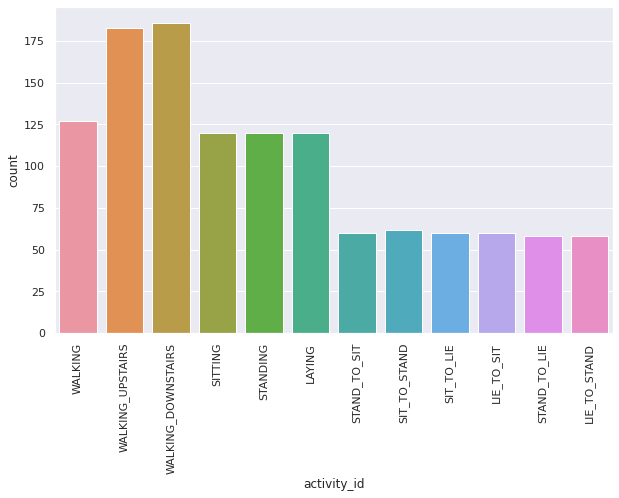

In [134]:
fig, ax = plt.subplots(figsize=(10,6))    
sns.set_theme(style="darkgrid")
sns.countplot(x='activity_id', data=df)
ax.set_xticklabels(labels['activity'].to_list(),rotation=90)
plt.show()

In [70]:
df['activity_length'] = df['label_end'] - df['label_start']

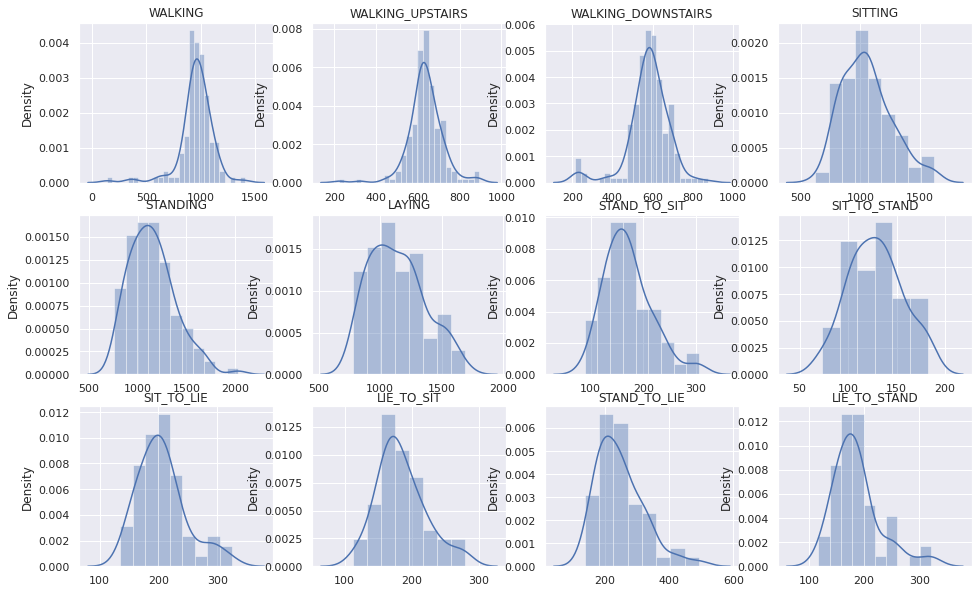

In [117]:
fig, axes = plt.subplots(figsize=(16,10), ncols=4, nrows=3)
for i, ax in zip(range(1, 13), axes.flat):
    sns.distplot(df[df['activity_id'] == i].loc[:, ['activity_length']], ax=ax)
    ax.set_title(labels.loc[labels['activity_id'] == i]['activity'].item())
plt.show()

In [143]:
df.loc[df['experiment_id'] == 1, ['label_start']].iloc[0].item()

250

In [146]:
start_times = []
for expt in df['experiment_id'].unique():
    st = df.loc[df['experiment_id'] == expt, ['label_start']].iloc[0].item()
    start_times.append([expt, st])

In [151]:
st = pd.DataFrame(start_times, columns=['expt', 'st'])

<AxesSubplot:xlabel='st', ylabel='Density'>

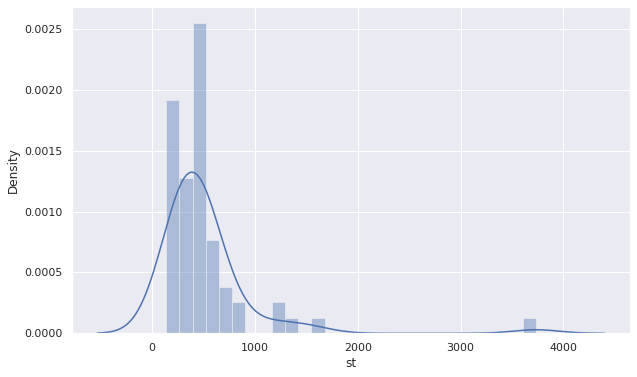

In [162]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(st['st'])

# Train, Val and Test Splits

In [186]:
total_users = df['user_id'].unique().shape[0]
test_ct = math.floor(0.3 * total_users)
val_ct = math.floor(0.3 * (total_users - test_ct))
train_ct = total_users - test_ct - val_ct
print (train_ct, val_ct, test_ct) 

15 6 9


In [182]:
users_list = list(shuffle(df['user_id'].unique()))

In [185]:
train_users = users_list[:train_ct]
val_users = users_list[train_ct:train_ct+val_ct]
test_users = users_list[train_ct+val_ct:]
print (len(train_users), len(val_users), len(test_users)) 

15 6 9


In [509]:
def get_label(user, expt, start, end):
    label_idx = df[(df['user_id'] == user) & (df['experiment_id'] == expt) & (start >= df['label_start'])].index[-1]
    
    if end <= df.iloc[label_idx, :]['label_end']:
        return df.iloc[label_idx, :]['activity_id']
    else:
        return -1
    
#     except:
#         print (user, expt, start, end)
#     a = np.empty(0, int)
#     curr_start = start - 1

#     curr_label_end = df.iloc[label_idx, :]['label_end'] - 1
#     curr_activity = df.iloc[label_idx, :]['activity_id']
#     curr_end = min(end, curr_label_end)

#     try:
#         a = np.append(a, np.repeat(curr_activity, curr_end-curr_start))
#     except:
#         print (curr_end, curr_start)
        
#     while (end > curr_label_end):
#         label_idx += 1
#         curr_start = df.iloc[label_idx, :]['label_start'] - 1
#         curr_label_end = df.iloc[label_idx, :]['label_end'] - 1
#         curr_activity = df.iloc[label_idx, :]['activity_id']
#         curr_end = min(end, curr_label_end)
#         try:
#             a = np.append(a, np.repeat(curr_activity, curr_end-curr_start))
#         except:
#             print (user, expt, start, end, curr_end, curr_start)
#     return np.amax(a)

In [523]:
def get_segments(user, expt, window=50):
    start = df.loc[df['experiment_id'] == expt, ['label_start']].iloc[0].item() - 1
    end = start + window
    pre_expt = pre_user = ''
    
    if expt < 10:
        pre_expt = '0'
    if user < 10:
        pre_user = '0'
        
    file_acc = 'RawData/acc_exp' + pre_expt + '%d_user' % (expt) + pre_user + '%d.txt' % (user)
    file_gyro = 'RawData/gyro_exp' + pre_expt + '%d_user' % (expt) + pre_user + '%d.txt' % (user)
    
    
    df_acc = pd.read_csv(file_acc, header=None, delim_whitespace=True, names=['a1', 'a2', 'a3'])
    df_gyro = pd.read_csv(file_gyro, header=None, delim_whitespace=True, names=['g1', 'g2', 'g3'])

    assert df_acc.shape[0] == df_gyro.shape[0]

    df_sensor = pd.concat([df_acc, df_gyro], axis=1)
    df_out = np.empty((0, window, 6), float)
    labels = []
    
    while (end < df_acc.shape[0]):
        label = get_label(user, expt, start+1, end+1)
        if label == -1:
            start += 25
            end += 25
            continue
        labels.append(label)
        curr_window = np.reshape(np.array(df_sensor.iloc[list(range(start, end)), :]), (1,window,6))
        df_out = np.append(df_out, curr_window, axis=0)
        start += 25
        end += 25
    return df_out, np.array(labels)

In [483]:
user = 10
expt = 19
window = 50

In [531]:
def read_data(users):
    df_out = np.empty((0, window, 6), float)
    labels = np.empty(0, int)
    for user in users:
        experiments = df.loc[df['user_id'] == user].experiment_id.unique()
        for expt in experiments:
            signals, l = get_segments(user, expt)
            df_out = np.append(df_out, signals, axis=0)
            labels = np.append(labels, l)
    return df_out, np.array(labels)

In [537]:
train_signals, train_labels = read_data(train_users)
val_signals, val_labels = read_data(val_users)
test_signals, test_labels = read_data(test_users)
print (train_signals.shape, val_signals.shape, test_signals.shape)
print (train_labels.shape, val_labels.shape, test_labels.shape)

(15119, 50, 6) (6157, 50, 6) (8965, 50, 6)
(15119,) (6157,) (8965,)


In [534]:
def get_features(signal):
    
    functions = [np.mean, np.std, np.amax, np.amin, np.quantile]
    function_args = {np.quantile: [[0.25, 0.75]]}
    function_kwargs = {np.mean: {'axis': 0}, np.std: {'axis': 0}, np.amax: {'axis': 0}, np.amin: {'axis': 0}, np.quantile: {'axis': 0}}
    features = []
    for f in functions:
        args = []
        args += function_args.get(f, [])
        kwargs = function_kwargs.get(f, {})

        features += list(f(signal, *args, **kwargs).flatten())
        
    return features

In [535]:
def create_df(data_df):
    n_rows = data_df.shape[0]
    features = []

    for i in range(n_rows):
        signal = data_df[i,:,:]
        features.append(get_features(signal))
    return np.array(features)

In [536]:
train_df = create_df(train_signals)
test_df = create_df(test_signals)
val_df = create_df(val_signals)
print (train_df.shape, test_df.shape, val_df.shape)

(15119, 36) (8965, 36) (6157, 36)
